<a href="https://colab.research.google.com/github/8bitnand/Blogs/blob/main/Compression%20of%20DNN/compression_of_NNs_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Compression of YOLO

##### Pre requisites 

In [4]:
# yolo
# install dependencies
# ! touch "/content/drive/MyDrive/Colab Notebooks/Compression of NN/requirements.txt"
! pip install -r "/content/drive/MyDrive/Colab Notebooks/Compression of NN/requirements.txt" -q # from https://github.com/hustvl/YOLOP/blob/main/requirements.txt 
!python -m pip install torchinfo -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.3 MB/s eta 0:00:00


In [ ]:
# kaggle data https://www.kaggle.com/general/74235 
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp "/content/drive/MyDrive/Colab Notebooks/Compression of NN/kaggle.json" ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d aadityadamle/bdd10k 
# ! unzip "/content/drive/MyDrive/Colab Notebooks/Compression of NN/bdd10k.zip" -d "/content/drive/MyDrive/Colab Notebooks/Compression of NN/"
# ! rm -r "/content/drive/MyDrive/Colab Notebooks/Compression of NN/bdd10k/train" "/content/drive/MyDrive/Colab Notebooks/Compression of NN/bdd10k/val" 

##### Imports

In [5]:
import torch
import cv2
import torchvision.transforms as t
from PIL import Image, ImageDraw
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/Compression of NN")
from utils import *
import matplotlib.pyplot  as plt
import json
import torch.nn.utils.prune as prune
from torchinfo import summary
from torch.utils.data import Dataset
from torchvision.io import read_image
import time 
%matplotlib inline


#### YOLOP model

##### Utils 

In [6]:
# https://discuss.pytorch.org/t/finding-model-size/130275
# utils 
transform = t.Compose([
    t.CenterCrop((640, 640)),
    t.ToTensor(),
    t.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


def transform_image(image_path) :
  image = Image.open(image_path)
  image = transform(image) 
  image = torch.unsqueeze(image, dim=0)
  # image = torch.permute(image)
  return image 

def model_size(model) :
  """return model size in MB"""

  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  return size_all_mb

def infer_one_img (model, img_path, show_img=None) :

  img_t = transform_image(img_path)
  img_det = cv2.imread(img_path)
  model = model.eval()
  with torch.no_grad():
    t = time.time()
    det_out, _, _ = model(img_t)
    ellapseed_time = time.time() - t 
  print(f"Ellapsed time : {ellapseed_time}")  
  inf_out, _ = det_out
  det_pred = non_max_suppression(inf_out, conf_thres=0.5, iou_thres=0.5, classes=None, agnostic=False)
  _, _, height, width = img_t.shape  # transformed imag 
  h,w,_ = img_det.shape   # original img 
  det = det_pred[0]
  det[:,:4] = scale_coords(img_t.shape[2:], det[:,:4], img_det.shape).round()

  if show_img :
    for *xyxy,conf,cls in reversed(det):
      if conf > 0.8 :
        plot_one_box(xyxy, img_det , color=[255]*3, line_thickness=4)
  
    plt.imshow(img_det)

def plot_weight_distribution (weights, title):
  with torch.no_grad():

    plt.title(title)
    plt.hist(weights, bins=256, color = "black")
    plt.show()


##### Summarry

In [60]:
yolop = torch.hub.load('hustvl/yolop', 'yolop', pretrained=True)

Using cache found in /root/.cache/torch/hub/hustvl_yolop_main


In [45]:
summary(yolop)

Layer (type:depth-idx)                             Param #
MCnet                                              --
├─Sequential: 1-1                                  --
│    └─Focus: 2-1                                  --
│    │    └─Conv: 3-1                              3,520
│    └─Conv: 2-2                                   --
│    │    └─Conv2d: 3-2                            18,432
│    │    └─BatchNorm2d: 3-3                       128
│    │    └─Hardswish: 3-4                         --
│    └─BottleneckCSP: 2-3                          --
│    │    └─Conv: 3-5                              2,112
│    │    └─Conv2d: 3-6                            2,048
│    │    └─Conv2d: 3-7                            1,024
│    │    └─Conv: 3-8                              4,224
│    │    └─BatchNorm2d: 3-9                       128
│    │    └─LeakyReLU: 3-10                        --
│    │    └─Sequential: 3-11                       10,368
│    └─Conv: 2-4                                   -

In [61]:
model_size(yolop)

30.380828857421875

In [39]:
# └─Conv: 2-8                                   --
# │    │    └─Conv2d: 3-32                           1,179,648
# │    │    └─BatchNorm2d: 3-33                      1,024
# │    │    └─Hardswish: 3-34                        --

# (7): Conv(
#       (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#       (bn): BatchNorm2d(512, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
#       (act): Hardswish()
#     )

weights_reshape = yolop.model[7].conv.weight.reshape(-1) 

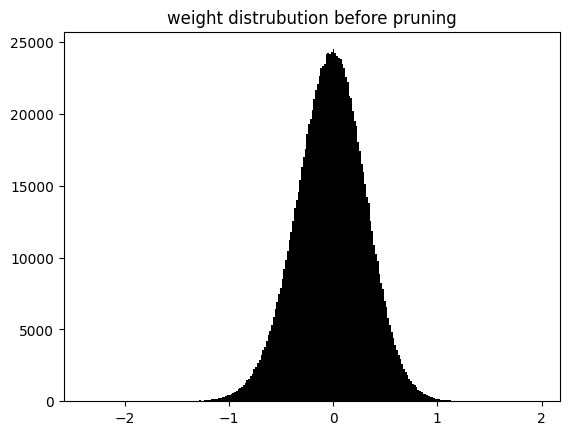

In [13]:
# weight distrubution 
plot_weight_distribution(weights_reshape, "weight distrubution before pruning")

In [68]:
# Test for base line 

img_path = "/content/drive/MyDrive/Colab Notebooks/Compression of NN/bdd10k/test/c7d69f1b-6f448654.jpg"
infer_one_img(yolop, img_path)

Ellapsed time : 0.6792542934417725


##### Pruninig

In [46]:
# unstructured pruning 
prune.random_unstructured(yolop.model[7].conv , name="weight", amount=0.5)

Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [47]:
summary(yolop)

Layer (type:depth-idx)                             Param #
MCnet                                              --
├─Sequential: 1-1                                  --
│    └─Focus: 2-1                                  --
│    │    └─Conv: 3-1                              3,520
│    └─Conv: 2-2                                   --
│    │    └─Conv2d: 3-2                            18,432
│    │    └─BatchNorm2d: 3-3                       128
│    │    └─Hardswish: 3-4                         --
│    └─BottleneckCSP: 2-3                          --
│    │    └─Conv: 3-5                              2,112
│    │    └─Conv2d: 3-6                            2,048
│    │    └─Conv2d: 3-7                            1,024
│    │    └─Conv: 3-8                              4,224
│    │    └─BatchNorm2d: 3-9                       128
│    │    └─LeakyReLU: 3-10                        --
│    │    └─Sequential: 3-11                       10,368
│    └─Conv: 2-4                                   -

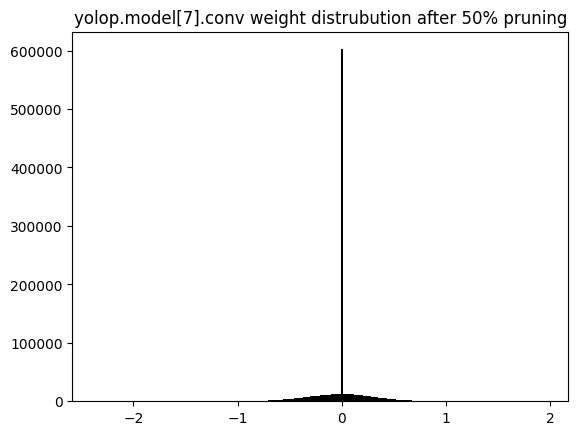

In [49]:
weights_reshape = yolop.model[7].conv.weight.reshape(-1)
plot_weight_distribution(weights_reshape, "yolop.model[7].conv weight distrubution after 50% pruning")

##### Test

In [50]:
model_size(yolop)

34.880828857421875

In [59]:
infer_one_img(yolop, img_path)

Ellapsed time : 0.5545139312744141


|layer| % of pruninig | size (MB)| time (s)|
|---|---|---|---|
**Unstructured pruninig**
|base model|0.0|30.38|0.564  - 0.67|
|yolop.model[7].conv|   0.2|34.88|0.562 - 0.543|
|yolop.model[7].conv|0.5|34.88|0.554 - 0.52|
**Global pruninig** 
|yolop.model[7].conv||
|yolop.model[8].cv2.conv||
|yolop.model[23].m[0].cv2.conv|0.4|43.63|

In [46]:
# Global pruninig

for name, params in yolop.named_parameters():
    if list(params.reshape(-1).shape)[0] > 5e5: print(name) 


model.7.conv.weight
model.8.cv2.conv.weight
model.9.m.0.cv2.conv.weight
model.21.conv.weight
model.23.m.0.cv2.conv.weight


In [82]:

yolop = torch.hub.load('hustvl/yolop', 'yolop', pretrained=True)

parameters_to_prune = (
    (yolop.model[7].conv, "weight"),
    (yolop.model[8].cv2.conv, "weight"),
    (yolop.model[9].m[0].cv2.conv, "weight"),
    (yolop.model[21].conv, "weight"),
    (yolop.model[23].m[0].cv2.conv, "weight" )
    )

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.4,
) 

Using cache found in /root/.cache/torch/hub/hustvl_yolop_main


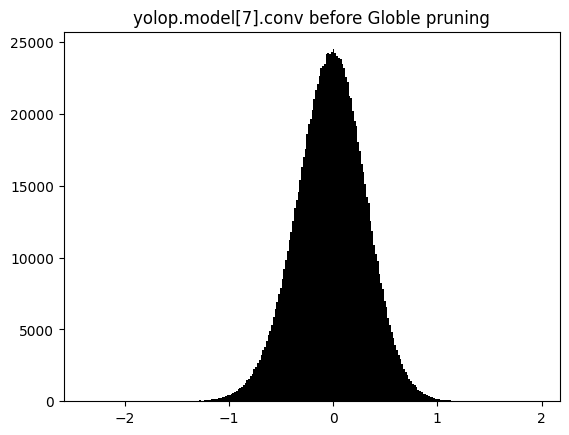

In [79]:
plot_weight_distribution(yolop.model[7].conv.weight.reshape(-1), "yolop.model[7].conv before Global pruning")

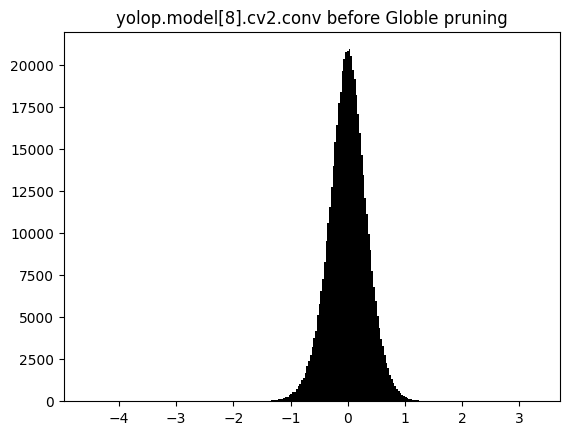

In [80]:
plot_weight_distribution(yolop.model[8].cv2.conv.weight.reshape(-1), "yolop.model[8].cv2.conv before Globle pruning")

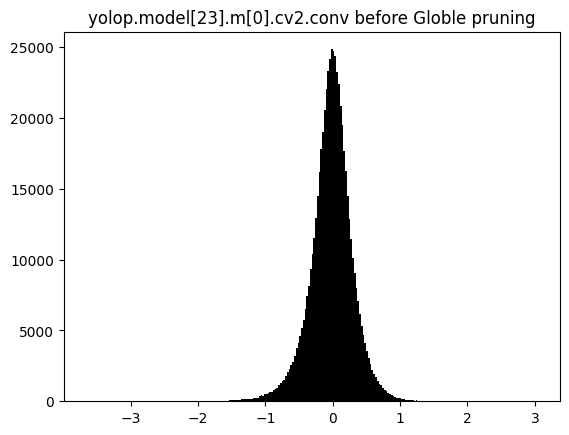

In [81]:
plot_weight_distribution(yolop.model[23].m[0].cv2.conv.weight.reshape(-1), "yolop.model[23].m[0].cv2.conv before Globle pruning")

Ellapsed time : 0.5671629905700684


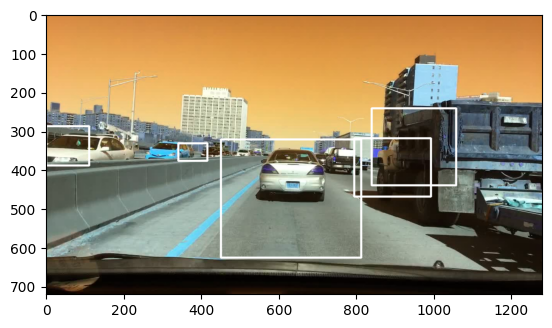

In [86]:
infer_one_img(yolop, img_path, show_img=True)

In [83]:

model_size(yolop)



43.630828857421875

In [ ]:
"""
base - 

─Conv: 2-8                                   --
│    │    └─Conv2d: 3-32                           1,179,648
│    │    └─BatchNorm2d: 3-33                      1,024
│    │    └─Hardswish: 3-34                        --

20% prunining 
─Conv: 2-8                                   --
│    │    └─Conv2d: 3-32                           943,718
│    │    └─BatchNorm2d: 3-33                      1,024
│    │    └─Hardswish: 3-34                        --

50% pruning 
└─Conv: 2-8                                   --
│    │    └─Conv2d: 3-32                           589,824
│    │    └─BatchNorm2d: 3-33                      1,024
│    │    └─Hardswish: 3-34                        --
"""